In [1]:
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import string
from nltk.stem import PorterStemmer
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional, GRU, MaxPooling1D, Conv1D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from gensim.models import Word2Vec, KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
import tensorflow as tf
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score

2024-07-22 19:36:46.175211: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/erezgilat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erezgilat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/erezgilat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Data set loading 

In [3]:
data = pd.read_csv("salafi_model_data.csv")

### Exploratory Data Analysis

In [4]:
data.head(4)

,tweet,label
0,This should be obvious to followers of Islam H...,Negative
1,May Allah make us from the righteous MuslimahG...,Negative
2,Due to the conference this weekend The Fiqh of...,Negative
3,Some simple facts about the predawn Sahr Meal ...,Positive


In [5]:
data['tweet'][1], data['label'][1]

('May Allah make us from the righteous MuslimahGoals Goals', 'Negative')

/var/folders/8b/3txm5_fd7h71v6z9jhwzy0j40000gn/T/ipykernel_46553/1844374916.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data['label'], label = "Count", palette="Set3")


<AxesSubplot:xlabel='count', ylabel='label'>

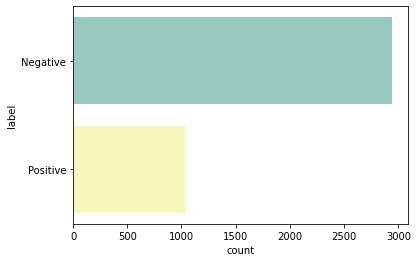

In [6]:
sns.countplot(data['label'], label = "Count", palette="Set3")

#### The first thing we can say is that we have more Negtive tweets (Anti-Salfia or Netural) than Positive(Pro-Salfia)

Word Cloud plotting for the most repeated words

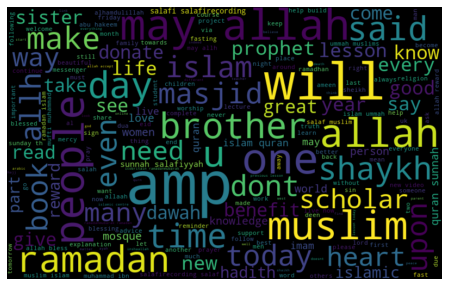

In [7]:
all_words = ' '.join([text for text in data['tweet']])
all_words = all_words.lower()
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We can see that the words Allah, Shaykh, Muslim and Ramadan are big and bold here, which means they repeat the most in the corpus
We want to find out of the most common words above how many appear in pro salfia context and how many in negative tweets

We need to balance the dataset because we have uneven number of tweets per santiment

In [8]:
# Redefine the keywords and results dictionary
keywords = ['allah', 'shaykh', 'muslim', 'ramadan', 'masjid', 'islam']
results = {keyword: {'Positive': 0, 'Negative': 0} for keyword in keywords}

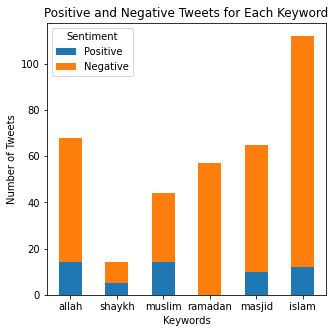

In [9]:
# Function to check if a keyword is in the tweet
def contains_keyword(tweet, keyword):
    return keyword in tweet
def keyword_analysis(data,keywords):
    # Calculate the number of positive and negative tweets for each keyword
    for keyword in keywords:
        for index, row in data.iterrows():
            if contains_keyword(row['tweet'], keyword):
                results[keyword][row['label']] += 1

    # Convert results to DataFrame
    results_df = pd.DataFrame(results).T
    results_df['keyword'] = results_df.index
    results_df = results_df.reset_index(drop=True)

    # Plotting
    results_df.plot(kind='bar', stacked=True, figsize=(5, 5))
    plt.xlabel('Keywords')
    plt.ylabel('Number of Tweets')
    plt.title('Positive and Negative Tweets for Each Keyword')
    plt.xticks(ticks=range(len(results_df)), labels=results_df['keyword'], rotation=0)
    plt.legend(title='Sentiment')
    plt.show()
keyword_analysis(data,keywords)

In [10]:
# Adding word count
data['word_count'] = data['tweet'].apply(lambda x: len(str(x).split()))
hist_num_tweets_by_word_count = data.groupby(['label'])['word_count'].value_counts().reset_index(name='count')

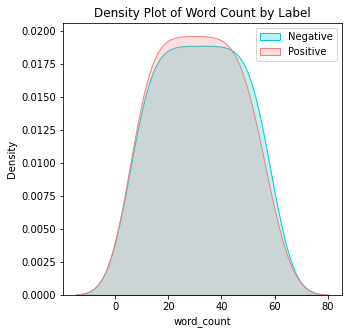

In [11]:
# Kde plot to show the distribution of the word count by label
plt.figure(figsize=(5,5))
sns.kdeplot(hist_num_tweets_by_word_count['word_count'][hist_num_tweets_by_word_count['label'] == "Negative"], color="darkturquoise", fill=True)
sns.kdeplot(hist_num_tweets_by_word_count['word_count'][hist_num_tweets_by_word_count['label'] == "Positive"], color="lightcoral", fill=True)
plt.legend(['Negative', 'Positive'])
plt.title('Density Plot of Word Count by Label')
plt.show()

In [12]:
# after seeing the distribution of the word count of each label we can see that its normal distribution
positive = data[data['label'] == 'Positive']
negative = data[data['label'] == 'Negative']
hist_num_tweets_by_word_count = pd.concat([positive,positive,positive,negative], ignore_index=True)
hist_num_tweets_by_word_count = hist_num_tweets_by_word_count[['label','word_count']].groupby('label').value_counts().unstack().T
hist_num_tweets_by_word_count = hist_num_tweets_by_word_count.groupby(pd.cut(hist_num_tweets_by_word_count.index, bins=range(0,60,3), right=False)).sum()
hist_num_tweets_by_word_count
hist_num_tweets_by_word_count['sum'] = hist_num_tweets_by_word_count['Negative'] + hist_num_tweets_by_word_count['Positive']
hist_num_tweets_by_word_count['Negative'] = hist_num_tweets_by_word_count['Negative'] / hist_num_tweets_by_word_count['sum']
hist_num_tweets_by_word_count['Positive'] = hist_num_tweets_by_word_count['Positive'] / hist_num_tweets_by_word_count['sum']
hist_num_tweets_by_word_count = hist_num_tweets_by_word_count.drop(columns=['sum'])

<Figure size 864x576 with 0 Axes>

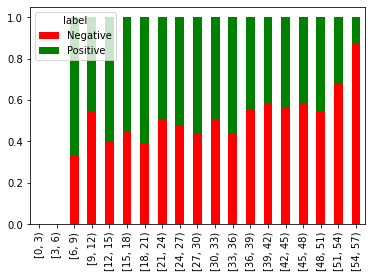

In [13]:
plt.figure(figsize=(12,8))
__ = hist_num_tweets_by_word_count.plot(kind='bar', stacked=True, color=['red', 'green'])

# Preprocessing

In [14]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize text
    words = text.split()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
        
    # Stem words
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
        
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]


    return ' '.join(words)

In [15]:
data['tweet'] = data['tweet'].apply(preprocess_text)
data['label'] = data['label'].map({'Positive': 1, 'Negative': 0})


# Data Balancing

### Down sampling

In [16]:
# Separate positive and negative tweets
positive_tweets = data[data['label'] == 1]
negative_tweets = data[data['label'] == 0]
# Downsample negative tweets
negative_tweets_downsampled = negative_tweets.sample(len(positive_tweets), random_state=1)
# Combine positive tweets with downsampled negative tweets
balanced_data_undersample = pd.concat([positive_tweets, negative_tweets_downsampled])

Above I used random under sampling, its interesting to see that ramadan appears only in Negative santiment and Muslim appears more in Positive.

I also tried creating more positive tweets syntaticly using Gen AI.

### New generated tweets syntatic over sampling
I used ChatGPT 4o to generate 2000 new tweets based on positive_tweets 

the prompt was "Generate 2000 tweets that are similar to the positive tweets in the dataset I gave you and make sure they are coherent and make sense."


In [17]:
# Load the generated tweets
generated_positive_tweets = pd.read_csv("generated_positive_tweets.csv")
generated_positive_tweets['label'] = 1
generated_positive_tweets.head(4)
# Take only number of tweets that equel num of negative tweets - num of positive tweets before balancing
generated_positive_tweets = generated_positive_tweets[:len(negative_tweets)-len(positive_tweets)]

In [18]:
# Concatenate the generated tweets with the original data
balanced_data_new_generated = pd.concat([data, generated_positive_tweets])

In [19]:
balanced_data_new_generated['label'].value_counts()

0    2941
1    2941
Name: label, dtype: int64

# TF-IDF MODEL 

## SVM model

### TF- IDF on the data as it is 

In [20]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['label'], test_size=0.2, random_state=47, stratify=data['label'])

# Apply TfidfVectorizer to the training data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data using the already fitted vectorizer
X_test_tfidf = vectorizer.transform(X_test)

# Create a support vector classifier
clf = SVC(kernel='linear')

# Train the classifier
clf.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test_tfidf)

In [21]:
print("Test acurrecy score: ", accuracy_score(y_test, y_pred))
print("Train acurrecy score: ", accuracy_score(y_train, clf.predict(X_train_tfidf)))
print("auc: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# weighted average of the precision, recall, and F1 score
print("f1_score: ", f1_score(y_test, y_pred, average='weighted'))
print("recall_score: ", recall_score(y_test, y_pred, average='weighted'))
print("precision_score: ", precision_score(y_test, y_pred, average='weighted'))



Test acurrecy score:  0.9132075471698113
Train acurrecy score:  0.9615869017632241
auc:  0.8546203042840423
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       589
           1       0.92      0.73      0.81       206

    accuracy                           0.91       795
   macro avg       0.91      0.85      0.88       795
weighted avg       0.91      0.91      0.91       795

f1_score:  0.9098713319432437
recall_score:  0.9132075471698113
precision_score:  0.9133340593717951


### TF- IDF on the balanced data that was undersampled

In [22]:
# Extract the features and labels
X = balanced_data_undersample['tweet']
y = balanced_data_undersample['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47, stratify=y)

# Apply TfidfVectorizer to the training data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data using the already fitted vectorizer
X_test_tfidf = vectorizer.transform(X_test)

# Create a support vector classifier
clf = SVC(kernel='linear')

# Train the classifier
clf.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test_tfidf)

In [23]:
print("Test acurrecy score: ", accuracy_score(y_test, y_pred))
print("Train acurrecy score: ", accuracy_score(y_train, clf.predict(X_train_tfidf)))
print("auc: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# weighted average of the precision, recall, and F1 score
print("f1_score: ", f1_score(y_test, y_pred, average='weighted'))
print("recall_score: ", recall_score(y_test, y_pred, average='weighted'))
print("precision_score: ", precision_score(y_test, y_pred, average='weighted'))


Test acurrecy score:  0.8470873786407767
Train acurrecy score:  0.9678398058252428
auc:  0.8470873786407768
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       206
           1       0.85      0.84      0.85       206

    accuracy                           0.85       412
   macro avg       0.85      0.85      0.85       412
weighted avg       0.85      0.85      0.85       412

f1_score:  0.8470864777928985
recall_score:  0.8470873786407767
precision_score:  0.8470955579121009


### TF-IDF Using new generated data

In [24]:
# This model uses CHAT GPT generated positive tweets - which means that it could have some bias 
# Extract the features and labels
X = balanced_data_new_generated['tweet']
y = balanced_data_new_generated['label']

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47, stratify=y)

# Apply TfidfVectorizer to the training data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data using the already fitted vectorizer
X_test_tfidf = vectorizer.transform(X_test)

# Create a support vector classifier
clf = SVC(kernel='linear')

# Train the classifier
clf.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test_tfidf)

In [25]:
print("Test acurrecy score: ", accuracy_score(y_test, y_pred))
print("Train acurrecy score: ", accuracy_score(y_train, clf.predict(X_train_tfidf)))
print("auc: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# weighted average of the precision, recall, and F1 score
print("f1_score: ", f1_score(y_test, y_pred, average='weighted'))
print("recall_score: ", recall_score(y_test, y_pred, average='weighted'))
print("precision_score: ", precision_score(y_test, y_pred, average='weighted'))


Test acurrecy score:  0.9328802039082413
Train acurrecy score:  0.9727948990435706
auc:  0.9329054202326091
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       588
           1       0.96      0.90      0.93       589

    accuracy                           0.93      1177
   macro avg       0.93      0.93      0.93      1177
weighted avg       0.93      0.93      0.93      1177

f1_score:  0.9328224997358949
recall_score:  0.9328802039082413
precision_score:  0.9344200131641974


### Over Sampling using SMOTE and TF-IDF

In [26]:
# Extract the features and labels
X = data['tweet']
y = data['label']

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47, stratify=y)

# Apply TfidfVectorizer to the training data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data using the already fitted vectorizer
X_test_tfidf = vectorizer.transform(X_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=47)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Create a support vector classifier
svm = SVC(kernel='linear')

# Train the classifier
svm.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = svm.predict(X_test_tfidf)

In [27]:
print("Test acurrecy score: ", accuracy_score(y_test, y_pred))
print("Train acurrecy score: ", accuracy_score(y_train, svm.predict(X_train_tfidf)))
print("auc:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# weighted average of the precision, recall, and F1 score
print("f1_score: ", f1_score(y_test, y_pred, average='weighted'))
print("recall_score: ", recall_score(y_test, y_pred, average='weighted'))
print("precision_score: ", precision_score(y_test, y_pred, average='weighted'))


Test acurrecy score:  0.909433962264151
Train acurrecy score:  0.9826826196473551
auc: 0.8773262234822885
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       589
           1       0.83      0.81      0.82       206

    accuracy                           0.91       795
   macro avg       0.88      0.88      0.88       795
weighted avg       0.91      0.91      0.91       795

f1_score:  0.9089942298465395
recall_score:  0.909433962264151
precision_score:  0.9086833676866973


## Deep learning model using TF-IDF and SMOTE

Epoch 1/5
74/74 [==============================] - 4s 50ms/step - loss: 0.6906 - accuracy: 0.5438 - val_loss: 0.6848 - val_accuracy: 0.8415 - lr: 1.0000e-04
Epoch 2/5
74/74 [==============================] - 3s 47ms/step - loss: 0.6784 - accuracy: 0.6932 - val_loss: 0.6712 - val_accuracy: 0.8654 - lr: 1.0000e-04
Epoch 3/5
74/74 [==============================] - 3s 46ms/step - loss: 0.6472 - accuracy: 0.8025 - val_loss: 0.6233 - val_accuracy: 0.8730 - lr: 1.0000e-04
Epoch 4/5
74/74 [==============================] - 4s 48ms/step - loss: 0.5609 - accuracy: 0.8667 - val_loss: 0.5064 - val_accuracy: 0.8780 - lr: 1.0000e-04
Epoch 5/5
74/74 [==============================] - 4s 57ms/step - loss: 0.4163 - accuracy: 0.8997 - val_loss: 0.3841 - val_accuracy: 0.8868 - lr: 1.0000e-04


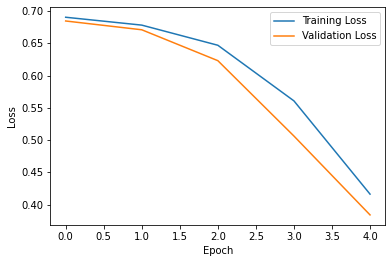

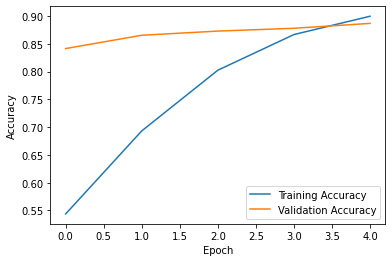

In [28]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['label'], test_size=0.2, random_state=47, stratify=data['label'])

# Apply TfidfVectorizer to the training data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert the sparse matrix to a dense matrix
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Define a Keras sequential model
model = Sequential()

# Add input layer
model.add(Dense(512, input_shape=(X_resampled.shape[1],), activation='relu'))

# Add dropout layer
model.add(Dropout(0.7))

# Add a dense layer
model.add(Dense(256, activation='relu'))

# Add dropout layer
model.add(Dropout(0.7))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Train the model
history = model.fit(X_resampled, y_resampled, validation_data=(X_test_tfidf, y_test), epochs=5, batch_size=64, callbacks=[early_stopping, reduce_lr])

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
# Sequantial model prediction
y_pred = model.predict(X_test_tfidf)
y_pred = np.round(y_pred).astype(int)

y_train_pred = model.predict(X_resampled)
y_train_pred = np.round(y_train_pred).astype(int)

print("Test acurrecy score: ", accuracy_score(y_test, y_pred))
print("Train acurrecy score: ", accuracy_score(y_resampled, y_train_pred))
print("auc:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# weighted average of the precision, recall, and F1 score
print("f1_score: ", f1_score(y_test, y_pred, average='weighted'))
print("recall_score: ", recall_score(y_test, y_pred, average='weighted'))
print("precision_score: ", precision_score(y_test, y_pred, average='weighted'))


147/147 [==============================] - 1s 4ms/step
Test acurrecy score:  0.8867924528301887
Train acurrecy score:  0.935374149659864
auc: 0.8415283432508613
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       589
           1       0.80      0.75      0.77       206

    accuracy                           0.89       795
   macro avg       0.86      0.84      0.85       795
weighted avg       0.88      0.89      0.89       795

f1_score:  0.8854661747384509
recall_score:  0.8867924528301887
precision_score:  0.8848257402713893


## Deep learning model using TF-IDF and original data

Epoch 1/10
50/50 [==============================] - 4s 57ms/step - loss: 0.6785 - accuracy: 0.6587 - val_loss: 0.6556 - val_accuracy: 0.7409 - lr: 1.0000e-04
Epoch 2/10
50/50 [==============================] - 3s 51ms/step - loss: 0.6334 - accuracy: 0.7409 - val_loss: 0.6043 - val_accuracy: 0.7409 - lr: 1.0000e-04
Epoch 3/10
50/50 [==============================] - 3s 50ms/step - loss: 0.5796 - accuracy: 0.7406 - val_loss: 0.5490 - val_accuracy: 0.7409 - lr: 1.0000e-04
Epoch 4/10
50/50 [==============================] - 3s 52ms/step - loss: 0.5272 - accuracy: 0.7406 - val_loss: 0.5116 - val_accuracy: 0.7409 - lr: 1.0000e-04
Epoch 5/10
50/50 [==============================] - 3s 51ms/step - loss: 0.4904 - accuracy: 0.7406 - val_loss: 0.4874 - val_accuracy: 0.7409 - lr: 1.0000e-04
Epoch 6/10
50/50 [==============================] - 3s 52ms/step - loss: 0.4642 - accuracy: 0.7431 - val_loss: 0.4654 - val_accuracy: 0.7535 - lr: 1.0000e-04
Epoch 7/10
50/50 [==============================] - 

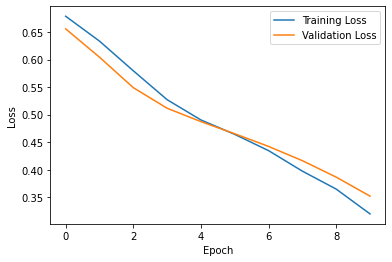

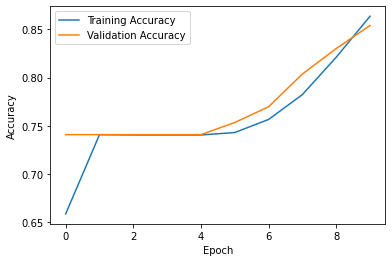

In [30]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['label'], test_size=0.2, random_state=47, stratify=data['label'])

# Apply TfidfVectorizer to the training data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert the sparse matrix to a dense matrix
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

# Define a Keras sequential model
model = Sequential()

# Add input layer
model.add(Dense(512, input_shape=(X_train_tfidf.shape[1],), activation='relu'))

# Add dropout layer
model.add(Dropout(0.7))

# Add a dense layer
model.add(Dense(256, activation='relu'))

# Add dropout layer
model.add(Dropout(0.7))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Train the model
history = model.fit(X_train_tfidf, y_train, validation_data=(X_test_tfidf, y_test), epochs=10, batch_size=64, callbacks=[early_stopping, reduce_lr])

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
# Sequantial model prediction
y_pred = model.predict(X_test_tfidf)
y_pred = np.round(y_pred).astype(int)

y_train_pred = model.predict(X_train_tfidf)
y_train_pred = np.round(y_train_pred).astype(int)

print("Test acurrecy score: ", accuracy_score(y_test, y_pred))
print("Train acurrecy score: ", accuracy_score(y_train, y_train_pred))
print("auc:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# weighted average of the precision, recall, and F1 score
print("f1_score: ", f1_score(y_test, y_pred, average='weighted'))
print("recall_score: ", recall_score(y_test, y_pred, average='weighted'))
print("precision_score: ", precision_score(y_test, y_pred, average='weighted'))


100/100 [==============================] - 0s 3ms/step
Test acurrecy score:  0.8540880503144654
Train acurrecy score:  0.8844458438287154
auc: 0.7294946181614387
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       589
           1       0.93      0.47      0.63       206

    accuracy                           0.85       795
   macro avg       0.89      0.73      0.77       795
weighted avg       0.87      0.85      0.84       795

f1_score:  0.8358968604179349
recall_score:  0.8540880503144654
precision_score:  0.8656909942399935


## Deep learning model using TF-IDF and over sampling positive class

Epoch 1/6
76/76 [==============================] - 5s 51ms/step - loss: 0.6912 - accuracy: 0.5334 - val_loss: 0.6926 - val_accuracy: 0.3925 - lr: 1.0000e-04
Epoch 2/6
76/76 [==============================] - 4s 49ms/step - loss: 0.6820 - accuracy: 0.6184 - val_loss: 0.6864 - val_accuracy: 0.5270 - lr: 1.0000e-04
Epoch 3/6
76/76 [==============================] - 4s 52ms/step - loss: 0.6600 - accuracy: 0.7114 - val_loss: 0.6622 - val_accuracy: 0.7497 - lr: 1.0000e-04
Epoch 4/6
76/76 [==============================] - 4s 50ms/step - loss: 0.6032 - accuracy: 0.8228 - val_loss: 0.5816 - val_accuracy: 0.8604 - lr: 1.0000e-04
Epoch 5/6
76/76 [==============================] - 4s 50ms/step - loss: 0.4955 - accuracy: 0.8719 - val_loss: 0.4618 - val_accuracy: 0.8692 - lr: 1.0000e-04
Epoch 6/6
76/76 [==============================] - 4s 48ms/step - loss: 0.3700 - accuracy: 0.9055 - val_loss: 0.3688 - val_accuracy: 0.8830 - lr: 1.0000e-04


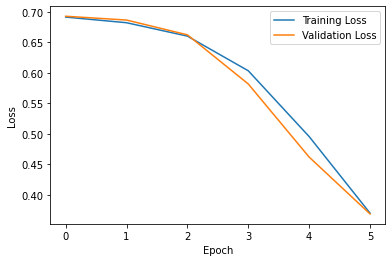

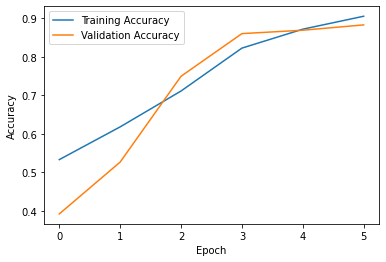

In [32]:
# Split the data into training and testing sets with stratification to two dataframes
df_train, df_test = train_test_split(data, test_size=0.2, random_state=47, stratify=data['label'])

# resampling the dummest way
df_train_positives = df_train[df_train['label'] == 1]
df_train_negatives = df_train[df_train['label'] == 0]

df_train_balanced = pd.concat([df_train_positives,df_train_positives,df_train_positives,df_train_negatives])

X_train = df_train_balanced['tweet']
y_train = df_train_balanced['label']
X_test = df_test['tweet']
y_test = df_test['label']

# Apply TfidfVectorizer to the training data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert the sparse matrix to a dense matrix
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

# Define a Keras sequential model
best2 = Sequential()

# Add input layer
best2.add(Dense(512, input_shape=(X_train_tfidf.shape[1],), activation='relu'))

# Add dropout layer
best2.add(Dropout(0.7))

# Add a dense layer
best2.add(Dense(256, activation='relu'))

# Add dropout layer
best2.add(Dropout(0.7))

# Add the output layer
best2.add(Dense(1, activation='sigmoid'))

# Compile the model
best2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Train the model
history = best2.fit(X_train_tfidf, y_train, validation_data=(X_test_tfidf, y_test), epochs=6, batch_size=64, callbacks=[early_stopping, reduce_lr])

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
# Sequantial model prediction
y_pred = best2.predict(X_test_tfidf)
y_pred = np.round(y_pred).astype(int)

y_train_pred = best2.predict(X_train_tfidf)
y_train_pred = np.round(y_train_pred).astype(int)

print("Test acurrecy score: ", accuracy_score(y_test, y_pred))
print("Train acurrecy score: ", accuracy_score(y_train, y_train_pred))
print("auc:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# weighted average of the precision, recall, and F1 score
print("f1_score: ", f1_score(y_test, y_pred, average='weighted'))
print("recall_score: ", recall_score(y_test, y_pred, average='weighted'))
print("precision_score: ", precision_score(y_test, y_pred, average='weighted'))


151/151 [==============================] - 0s 3ms/step
Test acurrecy score:  0.8830188679245283
Train acurrecy score:  0.945273631840796
auc: 0.8468730941038786
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       589
           1       0.78      0.77      0.77       206

    accuracy                           0.88       795
   macro avg       0.85      0.85      0.85       795
weighted avg       0.88      0.88      0.88       795

f1_score:  0.8829261654307309
recall_score:  0.8830188679245283
precision_score:  0.8828368185824488


# Word2Vec Model

## Word2Vec Model using pretrained

Epoch 1/50
76/76 [==============================] - 12s 121ms/step - loss: 0.6844 - accuracy: 0.5518 - val_loss: 0.6811 - val_accuracy: 0.6101 - lr: 1.0000e-04
Epoch 2/50
76/76 [==============================] - 9s 113ms/step - loss: 0.6593 - accuracy: 0.6240 - val_loss: 0.6513 - val_accuracy: 0.6679 - lr: 1.0000e-04
Epoch 3/50
76/76 [==============================] - 8s 104ms/step - loss: 0.6216 - accuracy: 0.6779 - val_loss: 0.6183 - val_accuracy: 0.6893 - lr: 1.0000e-04
Epoch 4/50
76/76 [==============================] - 8s 101ms/step - loss: 0.5866 - accuracy: 0.7127 - val_loss: 0.6001 - val_accuracy: 0.6981 - lr: 1.0000e-04
Epoch 5/50
76/76 [==============================] - 8s 99ms/step - loss: 0.5564 - accuracy: 0.7305 - val_loss: 0.5336 - val_accuracy: 0.7686 - lr: 1.0000e-04
Epoch 6/50
76/76 [==============================] - 8s 99ms/step - loss: 0.5305 - accuracy: 0.7523 - val_loss: 0.5477 - val_accuracy: 0.7572 - lr: 1.0000e-04
Epoch 7/50
76/76 [=============================

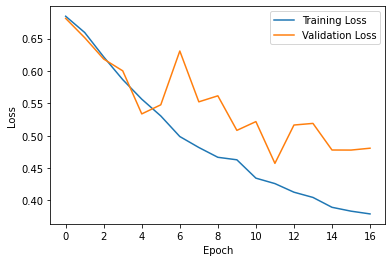

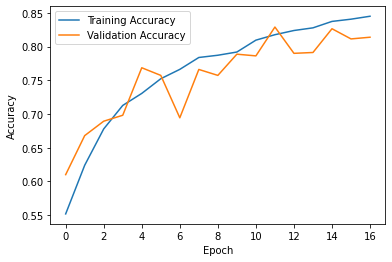

In [34]:
# Split the data into training and testing sets with stratification to two dataframes
df_train, df_test = train_test_split(data, test_size=0.2, random_state=47, stratify=data['label'])

# resampling the dummest way
df_train_positives = df_train[df_train['label'] == 1]
df_train_negatives = df_train[df_train['label'] == 0]

df_train_balanced = pd.concat([df_train_positives,df_train_positives,df_train_positives,df_train_negatives])

X_train = df_train_balanced['tweet']
y_train = df_train_balanced['label']
X_test = df_test['tweet']
y_test = df_test['label']

# create word2vec using gengim googlenews pretrained model
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

# Tokenize the training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
X_train = pad_sequences(X_train, padding='post', maxlen=100)
X_test = pad_sequences(X_test, padding='post', maxlen=100)

# Create an embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
for word, i in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

# Define a Keras sequential model
model = Sequential()

# Add embedding layer
model.add(Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=100, trainable=False))

# Add LSTM layer
model.add(LSTM(128, return_sequences=True))

# Add global max pooling layer
model.add(GlobalMaxPooling1D())

# Add dropout layer
model.add(Dropout(0.5))

# Add dense layer
model.add(Dense(64, activation='relu'))

# Add dropout layer
model.add(Dropout(0.5))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stopping, reduce_lr])


# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
# Sequantial model prediction
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

y_train_pred = model.predict(X_train)
y_train_pred = np.round(y_train_pred).astype(int)

print("Test acurrecy score: ", accuracy_score(y_test, y_pred))
print("Train acurrecy score: ", accuracy_score(y_train, y_train_pred))
print("auc:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# weighted average of the precision, recall, and F1 score
print("f1_score: ", f1_score(y_test, y_pred, average='weighted'))
print("recall_score: ", recall_score(y_test, y_pred, average='weighted'))
print("precision_score: ", precision_score(y_test, y_pred, average='weighted'))


151/151 [==============================] - 4s 28ms/step
Test acurrecy score:  0.8138364779874214
Train acurrecy score:  0.8586235489220564
auc: 0.7844009098851105
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       589
           1       0.62      0.72      0.67       206

    accuracy                           0.81       795
   macro avg       0.76      0.78      0.77       795
weighted avg       0.83      0.81      0.82       795

f1_score:  0.8181659810139377
recall_score:  0.8138364779874214
precision_score:  0.8256600940563205


## Word2Vec model using embeddings trained in place

Epoch 1/15
76/76 [==============================] - 6s 44ms/step - loss: 0.5505 - accuracy: 0.7143 - val_loss: 0.4444 - val_accuracy: 0.8289
Epoch 2/15
76/76 [==============================] - 3s 41ms/step - loss: 0.4529 - accuracy: 0.7942 - val_loss: 0.4944 - val_accuracy: 0.7623
Epoch 3/15
76/76 [==============================] - 3s 36ms/step - loss: 0.4213 - accuracy: 0.8074 - val_loss: 0.3971 - val_accuracy: 0.8264
Epoch 4/15
76/76 [==============================] - 3s 35ms/step - loss: 0.3944 - accuracy: 0.8215 - val_loss: 0.3376 - val_accuracy: 0.8566
Epoch 5/15
76/76 [==============================] - 3s 37ms/step - loss: 0.3651 - accuracy: 0.8375 - val_loss: 0.3809 - val_accuracy: 0.8403
Epoch 6/15
76/76 [==============================] - 3s 40ms/step - loss: 0.3542 - accuracy: 0.8379 - val_loss: 0.3631 - val_accuracy: 0.8541
Epoch 7/15
76/76 [==============================] - 3s 34ms/step - loss: 0.3331 - accuracy: 0.8528 - val_loss: 0.3114 - val_accuracy: 0.8855
Epoch 8/15
76

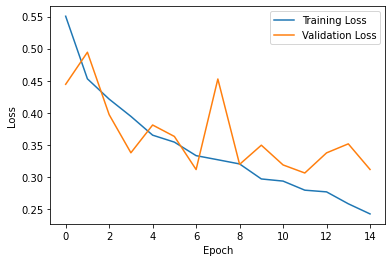

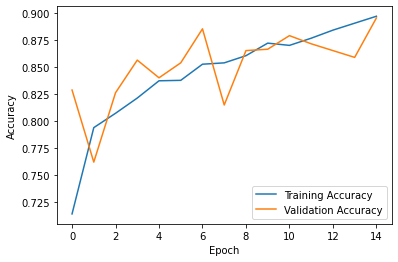

In [36]:
# Split the data into training and testing sets with stratification to two dataframes
df_train, df_test = train_test_split(data, test_size=0.2, random_state=47, stratify=data['label'])

# resampling the dummest way
df_train_positives = df_train[df_train['label'] == 1]
df_train_negatives = df_train[df_train['label'] == 0]

df_train_balanced = pd.concat([df_train_positives,df_train_positives,df_train_positives,df_train_negatives])

X_train = df_train_balanced['tweet']
y_train = df_train_balanced['label']
X_test = df_test['tweet']
y_test = df_test['label']

# Apply word tokenization
X_train_tokens = [word_tokenize(text) for text in X_train]
X_test_tokens = [word_tokenize(text) for text in X_test]

# Create Word2Vec embeddings
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)
w2v_model.train(X_train_tokens, total_examples=len(X_train_tokens), epochs=10)

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max([len(seq) for seq in X_train_seq])

X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=max_sequence_length)

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[index] = w2v_model.wv[word]

# Build LSTM model
best1 = Sequential()
best1.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
best1.add(SpatialDropout1D(0.2))
best1.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
best1.add(Dense(1, activation='sigmoid'))

# Compile the model
best1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = best1.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=15, batch_size=64
                    #, callbacks=[early_stopping, reduce_lr]
                    )

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
# Sequantial model prediction
y_pred = best1.predict(X_test_pad)
y_pred = np.round(y_pred).astype(int)

y_train_pred = best1.predict(X_train_pad)
y_train_pred = np.round(y_train_pred).astype(int)

print("Test acurrecy score: ", accuracy_score(y_test, y_pred))
print("Train acurrecy score: ", accuracy_score(y_train, y_train_pred))
print("auc:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# weighted average of the precision, recall, and F1 score
print("f1_score: ", f1_score(y_test, y_pred, average='weighted'))
print("recall_score: ", recall_score(y_test, y_pred, average='weighted'))
print("precision_score: ", precision_score(y_test, y_pred, average='weighted'))


151/151 [==============================] - 1s 9ms/step
Test acurrecy score:  0.8955974842767296
Train acurrecy score:  0.925787728026534
auc: 0.8727232267954572
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       589
           1       0.78      0.83      0.80       206

    accuracy                           0.90       795
   macro avg       0.86      0.87      0.87       795
weighted avg       0.90      0.90      0.90       795

f1_score:  0.8964629210908104
recall_score:  0.8955974842767296
precision_score:  0.8977325375748381


# Soft Voting combined algorithm

In [38]:
# Vote classifier
y_pred_prob1 = best1.predict(X_test_pad)
y_pred_prob2 = best2.predict(X_test_tfidf)

# If models output probabilities, average them
y_pred_prob_avg = (y_pred_prob1 + y_pred_prob2) / 2

# Convert averaged probabilities to binary predictions
y_pred_final = (y_pred_prob_avg > 0.5).astype(int)

print("Test acurrecy score: ", accuracy_score(y_test, y_pred_final))

# predict the training data
y_train_pred_prob1 = best1.predict(X_train_pad)
y_train_pred_prob2 = best2.predict(X_train_tfidf)

# If models output probabilities, average them
y_train_pred_prob_avg = (y_train_pred_prob1 + y_train_pred_prob2) / 2

# Convert averaged probabilities to binary predictions
y_train_pred_final = (y_train_pred_prob_avg > 0.5).astype(int)

print("Train acurrecy score: ", accuracy_score(y_train, y_train_pred_final))
print("auc:", roc_auc_score(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))
# weighted average of the precision, recall, and F1 score
print("f1_score: ", f1_score(y_test, y_pred, average='weighted'))
print("recall_score: ", recall_score(y_test, y_pred, average='weighted'))
print("precision_score: ", precision_score(y_test, y_pred, average='weighted'))


25/25 [==============================] - 0s 3ms/step
Test acurrecy score:  0.9081761006289308
151/151 [==============================] - 0s 3ms/step
Train acurrecy score:  0.9384328358208955
auc: 0.8827904791731913
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       589
           1       0.82      0.83      0.82       206

    accuracy                           0.91       795
   macro avg       0.88      0.88      0.88       795
weighted avg       0.91      0.91      0.91       795

f1_score:  0.8964629210908104
recall_score:  0.8955974842767296
precision_score:  0.8977325375748381


# Best model satistics 
### accuracy 0.908
### f1_score 0.896
### auc 0.88

In [39]:
# read the for_eli2.csv file and predict the labels for each content in the file
df = pd.read_csv('for_eli2.csv')
df['content'] = df['content'].apply(preprocess_text)
X_test = df['content']
X_test_tfidf = vectorizer.transform(X_test)
X_test_tfidf = X_test_tfidf.toarray()
X_test_tokens = [word_tokenize(text) for text in X_test]
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=max_sequence_length)

y_pred_prob1 = best1.predict(X_test_pad)
y_pred_prob2 = best2.predict(X_test_tfidf)

# If models output probabilities, average them
y_pred_prob_avg = (y_pred_prob1 + y_pred_prob2) / 2

# Convert averaged probabilities to binary predictions
y_pred_final = (y_pred_prob_avg > 0.5).astype(int)

df['label'] = y_pred_final
df.to_csv('predicted_labels.csv', index=False)



10/10 [==============================] - 0s 3ms/step


# BERT model


# convert_examples_to_features function
def convert_examples_to_features(examples, label_list, max_length, tokenizer):
    features = []
    for example in examples:
        input_dict = tokenizer.encode_plus(example.text_a, add_special_tokens=True, max_length=max_length, return_token_type_ids=True, return_attention_mask=True, padding='max_length', truncation=True)
        input_ids = input_dict['input_ids']
        attention_mask = input_dict['attention_mask']
        token_type_ids = input_dict['token_type_ids']
        label = label_list.index(example.label)
        features.append(InputFeatures(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=label))
    return features


# Split the data into training and testing sets with stratification to two dataframes
df_train, df_test = train_test_split(data, test_size=0.2, random_state=47, stratify=data['label'])

# resampling the dummest way
df_train_positives = df_train[df_train['label'] == 1]
df_train_negatives = df_train[df_train['label'] == 0]

df_train_balanced = pd.concat([df_train_positives,df_train_positives,df_train_positives,df_train_negatives])

X_train = df_train_balanced['tweet']
y_train = df_train_balanced['label']
X_test = df_test['tweet']
y_test = df_test['label']

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Assuming X_train, X_test, y_train, and y_test are already defined and contain text data

# Create InputExamples
train_input = [InputExample(guid=None, text_a=x, text_b=None, label=y) for x, y in zip(X_train, y_train)]
test_input = [InputExample(guid=None, text_a=x, text_b=None, label=y) for x, y in zip(X_test, y_test)]

# Convert InputExamples to InputFeatures
def convert_examples_to_features(examples, label_list, max_length, tokenizer):
    features = []
    for example in examples:
        input_dict = tokenizer.encode_plus(example.text_a, add_special_tokens=True, max_length=max_length, return_token_type_ids=True, return_attention_mask=True, padding='max_length', truncation=True)
        input_ids = input_dict['input_ids']
        attention_mask = input_dict['attention_mask']
        token_type_ids = input_dict['token_type_ids']
        label = label_list.index(example.label)

        features.append(InputFeatures(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=label))
    return features

train_features = convert_examples_to_features(train_input, label_list=[0, 1], max_length=128, tokenizer=tokenizer)
test_features = convert_examples_to_features(test_input, label_list=[0, 1], max_length=128, tokenizer=tokenizer)

# Extract the input_ids, attention_mask, and token_type_ids
X_train_input_ids = np.array([f.input_ids for f in train_features])
X_train_attention_mask = np.array([f.attention_mask for f in train_features])
X_train_token_type_ids = np.array([f.token_type_ids for f in train_features])

X_test_input_ids = np.array([f.input_ids for f in test_features])
X_test_attention_mask = np.array([f.attention_mask for f in test_features])
X_test_token_type_ids = np.array([f.token_type_ids for f in test_features])

# Train the model
model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit([X_train_input_ids, X_train_attention_mask, X_train_token_type_ids], y_train, validation_data=([X_test_input_ids, X_test_attention_mask, X_test_token_type_ids], y_test), epochs=3, batch_size=64)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()